# Application of backboning to stackoverflow daten

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import itertools 
from collections import defaultdict
from scipy.stats import binom, pearsonr, sem

#functions written by Coscia and Neffke 
import backboning_python3_networkx2_Coscia as backboning

### Investigate data

In [49]:
# read in co-occurance data 
df0 = pd.DataFrame()
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()
df5 = pd.DataFrame()
df6 = pd.DataFrame()
df7 = pd.DataFrame()
df8 = pd.DataFrame()
df9 = pd.DataFrame()

frames = [df0, df1, df2, df3]#, df2, df3, df4, df5, df6, df7, df8, df9]
df = pd.DataFrame()
df = df.astype(pd.SparseDtype("int", 0))

for num, frame in enumerate(frames): 
    try:
        intermed_df = pd.read_csv(f'../data/intermediate_frames/df{num}.csv')  
        df = pd.concat([df, intermed_df], axis=1)
        df = df.drop(columns=['Unnamed: 0'])
        df = df.copy()
        df = df.astype(pd.SparseDtype("int", 0))
    except FileNotFoundError: 
        pass

In [50]:
df.head()

,.htaccess,.net,.net-3.5,.net-4.0,.net-core,3d,access-vba,actionscript,actionscript-3,active-directory,...,hover,html,html-table,html5,html5-canvas,html5-video,http,http-headers,http-post,https
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
#'dense: {:0.2f} bytes'.format(df.memory_usage().sum() / 1e3)

In [56]:
#df = df.astype(pd.SparseDtype("int", 0))

In [53]:
'sparse: {:0.2f} bytes'.format(df.memory_usage().sum() / 1e3)

'sparse: 69559.28 bytes'

In [57]:
type(df[".net"][0])

int

In [58]:
colnames = df.columns
sm = df.sparse.to_coo() 
sm

<6604020x400 sparse matrix of type '<class 'numpy.int64'>'
	with 5796596 stored elements in COOrdinate format>

In [59]:
sm.T

<400x6604020 sparse matrix of type '<class 'numpy.int64'>'
	with 5796596 stored elements in COOrdinate format>

In [60]:
coocc = np.dot(sm.T, sm)
coocc

<400x400 sparse matrix of type '<class 'numpy.int64'>'
	with 74228 stored elements in Compressed Sparse Row format>

In [61]:
coocc = pd.DataFrame.sparse.from_spmatrix(coocc, index=colnames, columns=colnames)
coocc = coocc.sparse.to_dense()
np.fill_diagonal(coocc.values, 0)
coocc.head()

,.htaccess,.net,.net-3.5,.net-4.0,.net-core,3d,access-vba,actionscript,actionscript-3,active-directory,...,hover,html,html-table,html5,html5-canvas,html5-video,http,http-headers,http-post,https
.htaccess,0,2,0,0,0,0,0,1,4,4,...,0,599,0,57,0,8,193,61,5,422
.net,2,0,834,1354,915,46,12,6,25,427,...,3,716,17,81,1,7,473,54,30,112
.net-3.5,0,834,0,138,2,0,0,0,1,18,...,0,13,1,1,0,0,3,1,0,1
.net-4.0,0,1354,138,0,3,0,0,0,0,14,...,0,13,0,2,0,0,10,1,2,2
.net-core,0,915,2,3,0,0,0,0,0,10,...,0,5,0,3,0,0,13,4,1,4


In [62]:
#tag_df_asint = df.astype(int)

In [63]:
# cooccurence matrix to dictionary
coocc_dic = coocc.to_dict()

In [64]:
# create dataframe represnting a network
tag1_ls = []
frames = []

for tag1, tag_dic in coocc_dic.items():
    tag1_ls.append(tag1)
    frames.append(pd.DataFrame.from_dict(tag_dic, orient='index'))

network_df = pd.concat(frames, keys=tag1_ls)
network_df = network_df.reset_index().rename(columns = {"level_0" : "tag1", "level_1" : "tag2", 0: "cooccurence"})

In [65]:
network_df.head() # must have ["tag1", "tag2", "co_occurance_count"]

,tag1,tag2,cooccurence
0,.htaccess,.htaccess,0
1,.htaccess,.net,2
2,.htaccess,.net-3.5,0
3,.htaccess,.net-4.0,0
4,.htaccess,.net-core,0


In [67]:
#nodes.head()

In [68]:
network_df[(network_df["tag1"] == ".htaccess") & (network_df["tag2"] == ".net")]

,tag1,tag2,cooccurence
1,.htaccess,.net,2


In [69]:
network_df[(network_df["tag2"] == ".htaccess") & (network_df["tag1"] == ".net")] # Network is undirected, edge present in both directions

,tag1,tag2,cooccurence
400,.net,.htaccess,2


In [73]:
network_df = network_df.rename(columns = {"tag1" : "src", "tag2" : "trg", "cooccurence": "cooccurence"})
network_df.head()

,src,trg,cooccurence
0,.htaccess,.htaccess,0
1,.htaccess,.net,2
2,.htaccess,.net-3.5,0
3,.htaccess,.net-4.0,0
4,.htaccess,.net-core,0


In [74]:
network_df.to_csv(path_or_buf="../data/undirected_stackoverflow_network_from_raw_data_TEST.csv", sep='\t')

In [70]:
#Select only the colums we need
df_ = network_df[["tag1", "tag2", "cooccurence"]].copy()
unique_tag1 = len(df_["tag1"].unique())
unique_tag2 = len(df_["tag2"].unique())
all_tags = set(list(df_["tag1"].unique()) + list(df_["tag2"].unique()))
print(f"# unique tag1: {unique_tag1}")
print(f"# unique tag2: {unique_tag2}")
print(f"# all tags present: {len(all_tags)}")
df_.head()

# unique tag1: 400
# unique tag2: 400
# all tags present: 400


,tag1,tag2,cooccurence
0,.htaccess,.htaccess,0
1,.htaccess,.net,2
2,.htaccess,.net-3.5,0
3,.htaccess,.net-4.0,0
4,.htaccess,.net-core,0


In [71]:
del(df_)

## Perform backboning 

In [76]:
table, original_nodes, original_edges = backboning.read("../data/undirected_stackoverflow_network_from_raw_data_TEST.csv", column_of_interest = "cooccurence", undirected = True)

In [77]:
table.head()

,src,trg,nij
1,.htaccess,.net,2
7,.htaccess,actionscript,1
8,.htaccess,actionscript-3,4
9,.htaccess,active-directory,4
10,.htaccess,activerecord,1


In [78]:
original_nodes, original_edges

(400, 36914.0)

In [79]:
import settings_tab2

measure = "noise_corrected"
network = "stackoverflow"

In [80]:
edge_table = settings_tab2.measures[measure](table, undirected = True) # backboning takes place here 

Calculating NC score...


In [81]:
edge_table.head()

,src,trg,nij,score,sdev_cij
1,.htaccess,.net,2,-0.992347,0.087033
7,.htaccess,actionscript,1,-0.894495,0.421396
407,.net,actionscript,6,-0.939633,0.135010
2007,3d,actionscript,15,0.603271,NaN
8,.htaccess,actionscript-3,4,-0.879698,0.224325


### Find appropriate threshold

from the paper [p. 429]: “common values of δ are 1.28, 1.64, and 2.32, which approximate p-values of 0.1, 0.05, and 0.01.”

In [101]:
# set test threshold
# threshold = 2.32 # can also be set even higher if whished for
#threshold = 10000
threshold = 1000

In [102]:
# function from Coscia
def thresholding(table, threshold):
    """Reads a preprocessed edge table and returns only the edges supassing a significance threshold.
    Args:
    table (pandas.DataFrame): The edge table.
    threshold (float): The minimum significance to include the edge in the backbone.

    Returns:
    The network backbone.
    """
    
    table = table.copy()
    if "sdev_cij" in table:
        return table[(table["score"] - (threshold * table["sdev_cij"])) > 0][["src", "trg", "nij", "score"]]
    else:
        return table[table["score"] > threshold][["src", "trg", "nij", "score"]]

In [103]:
def apply_thresholding(edge_table, measure, threshold): 
    
    if measure in ["maximum_spanning_tree", "doubly_stochastic"]: 
        edge_table_thresholded = edge_table.copy()
    else: 
        edge_table_thresholded = thresholding(edge_table, threshold)
    return edge_table_thresholded

In [104]:
edge_table_thresholded = apply_thresholding(edge_table, measure, threshold)

In [105]:
edge_table.shape, edge_table_thresholded.shape # remaining edges 

((36914, 5), (262, 4))

In [106]:
len(edge_table)-len(edge_table_thresholded) # number of dropped edges by thresholding (1.28: 265703, 1.64: 310367, 2.32: 382907)

36652

<AxesSubplot:>

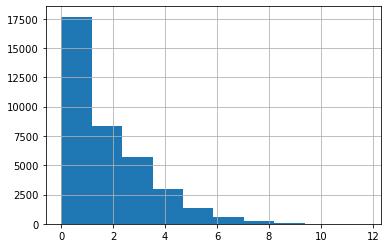

In [107]:
edge_table["nij"].map(lambda x: np.log(x)).hist()

<AxesSubplot:>

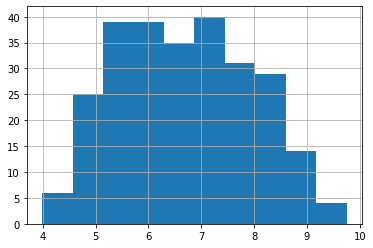

In [108]:
edge_table_thresholded["nij"].map(lambda x: np.log(x)).hist()

In [109]:
edge_table.head()

,src,trg,nij,score,sdev_cij
1,.htaccess,.net,2,-0.992347,0.087033
7,.htaccess,actionscript,1,-0.894495,0.421396
407,.net,actionscript,6,-0.939633,0.135010
2007,3d,actionscript,15,0.603271,NaN
8,.htaccess,actionscript-3,4,-0.879698,0.224325


### Apply backboning to thresholded data

In [110]:
def backbone_network(edge_table_thresholded, edge_table, table, original_nodes, original_edges): 
    
    original_nodes_thresh = len(set(edge_table_thresholded["src"]) | set(edge_table_thresholded["trg"]))
    original_edges_thresh = edge_table_thresholded.shape[0]

    print(f"Number of original nodes pre-thresholding: {original_nodes}")
    print(f"Number of original edges pre-thresholding: {int(original_edges)} \n")
    print(f"Number of original nodes post-thresholding: {original_nodes_thresh}")
    print(f"Number of original edges post-thresholding: {int(original_edges_thresh)} \n")
    
    print(f"Difference in nodes: {original_nodes-original_nodes_thresh}")
    print(f"Difference in edges: {int(original_edges-original_edges_thresh)}")
    
    G_threshold = nx.from_pandas_edgelist(edge_table_thresholded, "src", "trg")
    DiG_thresholded = G_threshold.to_directed()
    UnG_thresholded = G_threshold.to_undirected()
    G = nx.from_pandas_edgelist(edge_table, "src", "trg")
    G_raw = nx.from_pandas_edgelist(table, "src", "trg")
    
    return G, G_threshold, DiG_thresholded, UnG_thresholded, G_raw

In [111]:
G, G_threshold, DiG_thresholded, UnG_thresholded, G_raw = backbone_network(edge_table_thresholded, edge_table, table, original_nodes, original_edges)

Number of original nodes pre-thresholding: 400
Number of original edges pre-thresholding: 36914 

Number of original nodes post-thresholding: 281
Number of original edges post-thresholding: 262 

Difference in nodes: 119
Difference in edges: 36652


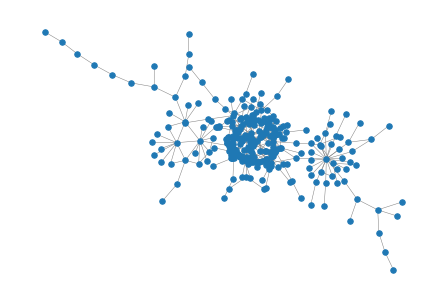

In [116]:
nx.draw_kamada_kawai(G_threshold, node_size = 30, edge_color = "gray", width = 0.5)

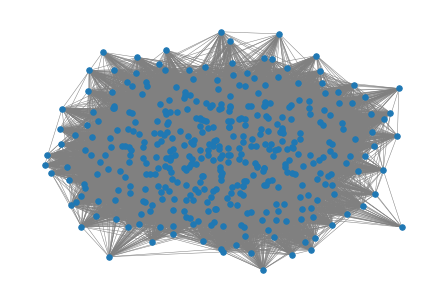

In [115]:
nx.draw(G, node_size = 30, edge_color = "gray", width = 0.5)

In [117]:
edge_table_thresholded.head(2)

,src,trg,nij,score
7620,amazon-ec2,amazon-s3,600,0.931057
4422,admob,android,1634,0.829342


### Everything in one function

In [ ]:
table, original_nodes, original_edges = backboning.read("../data/undirected_stackoverflow_network_from_raw_data_TEST.csv", column_of_interest = "cooccurence", undirected = True)

In [ ]:
def thresholding_and_backboning(table, threshold, original_nodes, original_edges): 
    
    """Reads a preprocessed edge table and returns only the edges supassing a significance threshold.
    Args:
    table (pandas.DataFrame): The edge table.
    threshold (float): The minimum significance to include the edge in the backbone.

    Returns:
    The network backbone.
    """
    
    # filter for significant edges (same method/thresholding-function as Coscia et al (2017))
    table = table.copy()
    
    if "sdev_cij" in table:
        return table[(table["score"] - (threshold * table["sdev_cij"])) > 0][["src", "trg", "nij", "score"]]
    else:
        return table[table["score"] > threshold][["src", "trg", "nij", "score"]]
    
    
    # apply thresholding (same method/function as Coscia et al (2017))
    if measure in ["maximum_spanning_tree", "doubly_stochastic"]: 
        edge_table_thresholded = edge_table.copy()
    else: 
        edge_table_thresholded = thresholding(edge_table, threshold)
        
    original_nodes_thresh = len(set(edge_table_thresholded["src"]) | set(edge_table_thresholded["trg"]))
    original_edges_thresh = edge_table_thresholded.shape[0]

    print(f"Number of original nodes pre-thresholding: {original_nodes}")
    print(f"Number of original edges pre-thresholding: {int(original_edges)} \n")
    print(f"Number of original nodes post-thresholding: {original_nodes_thresh}")
    print(f"Number of original edges post-thresholding: {int(original_edges_thresh)} \n")
    
    print(f"Difference in nodes: {original_nodes-original_nodes_thresh}")
    print(f"Difference in edges: {int(original_edges-original_edges_thresh)}")
    
    G_threshold = nx.from_pandas_edgelist(edge_table_thresholded, "src", "trg")
    G = nx.from_pandas_edgelist(edge_table, "src", "trg")
    
    return G, G_threshold

In [ ]:
def thresholding_and_backboning(table, threshold, original_nodes, original_edges)